In [1]:
# ! pip install opencv-python
# ! pip install pyhocon
# ! pip install plotly

In [60]:
# Import necessary libraries
import os
import numpy as np
from google.cloud import storage
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import glob
import log
import utils as ut
import plotly.express as px

In [3]:
# Set random seeds for reproducability
np.random.seed(0)
tf.random.set_seed(0)

# Define constants
NOISE_FACTOR = 0.1

In [66]:
def list_blobs_with_prefix(bucket_name, prefix):
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix)
    return [blob.name for blob in blobs]


def _get_bucket(bucket_name):
    storage_client = storage.Client()
    return storage_client.bucket(bucket_name)


def _read_image_from_gcs(bucket, blob_path):
    filename = storage.Blob(blob_path, bucket)
    file_as_bytes = filename.download_as_bytes()
    nparr = np.frombuffer(file_as_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img


# 1. Download and load the data
def load_data(bucket_name, filenames):
    bucket = _get_bucket(bucket_name)
    images = []
    for img_path in filenames:
        img = _read_image_from_gcs(bucket, img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        img = img / 255.0
        images.append(img)
    images = np.array(images)
    return images


# 2. Preprocess the data
def preprocess_data(images):
    images_noisy = images + NOISE_FACTOR * np.random.normal(loc=0.0, scale=1.0, size=images.shape) 
    images_noisy = np.clip(images_noisy, 0., 1.)
    return images_noisy


# 3. Split the data into training, validation, and test sets
def split_data(images_clean, images_noisy):
    # Split into train and rest
    images_clean_train, images_clean_rest, images_noisy_train, images_noisy_rest = train_test_split(images_clean, images_noisy, test_size=0.2, random_state=0)
    # Further split rest into validation and test
    images_clean_val, images_clean_test, images_noisy_val, images_noisy_test = train_test_split(images_clean_rest, images_noisy_rest, test_size=0.5, random_state=0)
    return images_clean_train, images_clean_val, images_clean_test, images_noisy_train, images_noisy_val, images_noisy_test


# 4. Create the Denoising Autoencoder model
# def create_model():
#     inputs = Input(shape=(64, 64, 3))
#     x = inputs

#     # Encoder
#     for i in range(2):
#         x = Conv2D(32*2**i, 3, strides=2, padding="same")(x)
#         x = BatchNormalization()(x)
#         x = ReLU()(x)
    
#     # Capture the shape before flattening
#     shape_before_flattening = K.int_shape(x)[1:]
    
#     x = Flatten()(x)
#     x = Dense(256)(x)

#     # Decoder
#     x = Dense(np.prod(shape_before_flattening))(x)
#     x = Reshape(shape_before_flattening)(x)

#     for i in range(2):
#         x = Conv2DTranspose(64//2**i, 3, strides=2, padding="same")(x)
#         x = BatchNormalization()(x)
#         x = ReLU()(x)

#     outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

#     # Create the model
#     model = Model(inputs, outputs)
#     return model

def create_model():
    # Encoder
    input_img = Input(shape=(64, 64, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # At this point the representation is (16, 16, 64)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # This model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# 5. Continue: Compile and train the model
def compile_and_train_model(model, images_clean_train, images_noisy_train, images_clean_test, images_noisy_test):
    model.compile(optimizer='adam', loss='mse')
    model.fit(images_noisy_train, images_clean_train, validation_data=(images_noisy_test, images_clean_test), epochs=10, batch_size=128)

    
# # 6. Evaluate the model
# def evaluate_model(model, images_noisy_test, images_clean_test):
#     images_denoised = model.predict(images_noisy_test)

#     # Compare clean, noisy, and denoised images
#     for i in range(5):
#         fig_clean = px.imshow(images_clean_test[i])
#         fig_clean.show()
        
#         fig_noisy = px.imshow(images_noisy_test[i])
#         fig_noisy.show()
        
#         fig_denoised = px.imshow(images_denoised[i])
#         fig_denoised.show()
        
def evaluate_model(model, images_noisy_test, images_clean_test):
    images_denoised = model.predict(images_noisy_test)

    # Compare clean, noisy, and denoised images
    for i in range(5):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(images_clean_test[i])
        ax[0].axis('off')
        ax[0].set_title('Clean')

        ax[1].imshow(images_noisy_test[i])
        ax[1].axis('off')
        ax[1].set_title('Noisy')

        ax[2].imshow(images_denoised[i])
        ax[2].axis('off')
        ax[2].set_title('Denoised')

        plt.show()

# 6. Evaluate the model
# def evaluate_model(model, images_noisy_test, images_clean_test):
#     images_denoised = model.predict(images_noisy_test)

#     # Compare clean, noisy, and denoised images
#     rows, cols = 1, 3
#     fig = plt.figure(figsize=(10, 5))
#     for i in range(5):
#         fig.add_subplot(rows, cols, 1)
#         plt.imshow(images_clean_test[i])
#         fig.add_subplot(rows, cols, 2)
#         plt.imshow(images_noisy_test[i])
#         fig.add_subplot(rows, cols, 3)
#         plt.imshow(images_denoised[i])
#         plt.show()

In [33]:
logger = log.get_logger(__name__)

30-Apr-23 23:14:24 - INFO - Starting 'load_config'.
30-Apr-23 23:14:24 - INFO - Finished 'load_config' in 0.0831 secs.


In [35]:
def main():
    conf = ut.load_config()
    faces_filenames = list_blobs_with_prefix(bucket_name=conf.gcp.bucket_name, prefix=conf.gcp.raw_lfwcrop_color_faces_prefix)
    images_clean = load_data(conf.gcp.bucket_name, faces_filenames[:100])
    images_noisy = preprocess_data(images_clean)
    images_clean_train, images_clean_val, images_clean_test, images_noisy_train, images_noisy_val, images_noisy_test = split_data(images_clean, images_noisy)
    model = create_model()
    compile_and_train_model(model, images_clean_train, images_noisy_train, images_clean_test, images_noisy_test)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0622 - val_loss: 0.0377
Epoch 2/10
1/1 [==============================] - 1s 669ms/step - loss: 0.0513 - val_loss: 0.0373
Epoch 3/10
1/1 [==============================] - 1s 679ms/step - loss: 0.0408 - val_loss: 0.0370
Epoch 4/10
1/1 [==============================] - 1s 612ms/step - loss: 0.0346 - val_loss: 0.0368
Epoch 5/10
1/1 [==============================] - 1s 655ms/step - loss: 0.0311 - val_loss: 0.0366
Epoch 6/10
1/1 [==============================] - 1s 588ms/step - loss: 0.0287 - val_loss: 0.0366
Epoch 7/10
1/1 [==============================] - 1s 621ms/step - loss: 0.0269 - val_loss: 0.0366
Epoch 8/10
1/1 [==============================] - 1s 587ms/step - loss: 0.0257 - val_loss: 0.0365
Epoch 9/10
1/1 [==============================] - 1s 585ms/step - loss: 0.0248 - val_loss: 0.0364
Epoch 10/10
1/1 [==============================] - 1s 594ms/step - loss: 0.0240 - val_loss: 0.0362


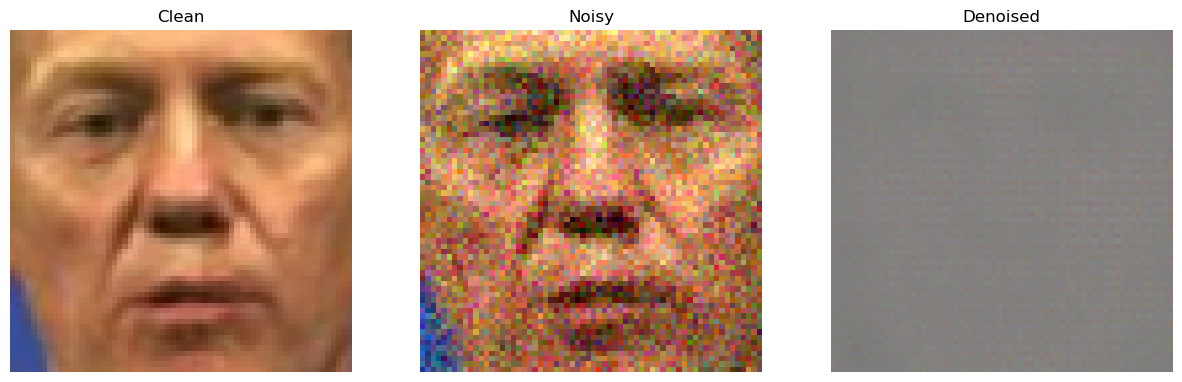

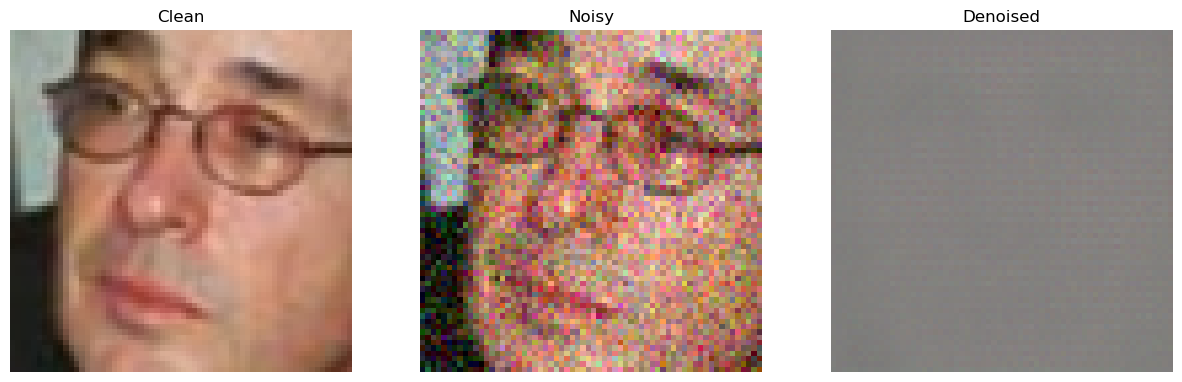

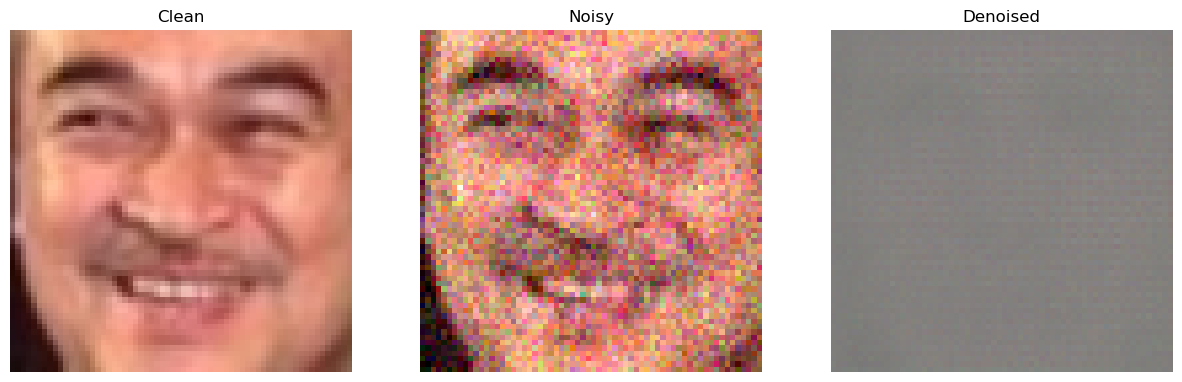

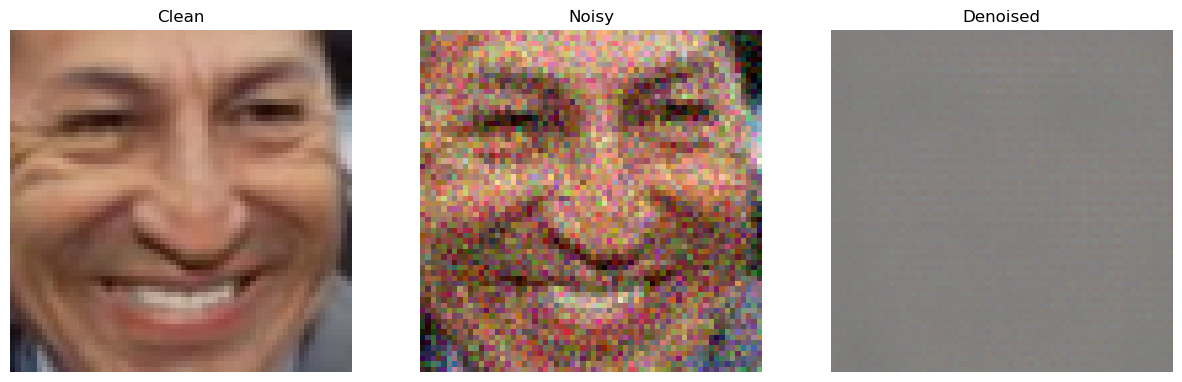

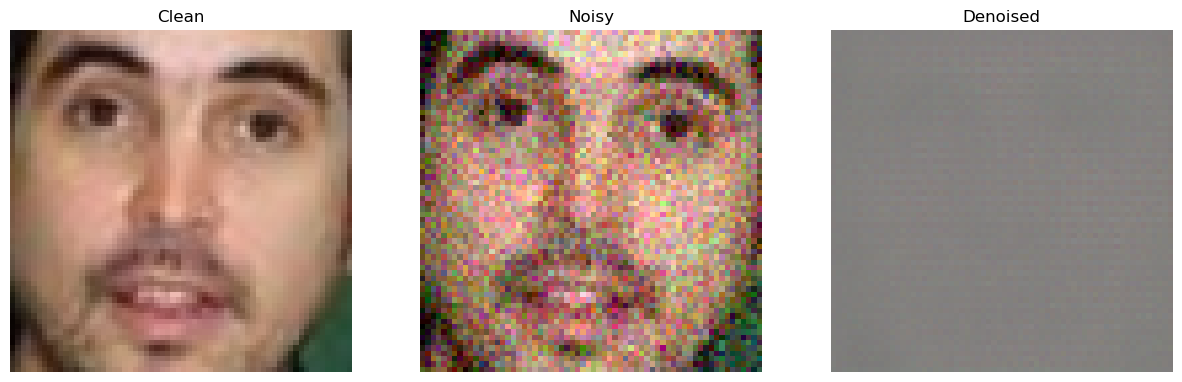

In [67]:
evaluate_model(model, images_noisy_test, images_clean_test)

In [ ]:
# def read_image_from_gcs(bucket_name, blob_path):
#     storage_client = storage.Client()
#     bucket = storage_client.bucket(bucket_name)
    
#     blob = storage.Blob(blob_path, bucket)
#     file_as_bytes = blob.download_as_bytes()
    
#     nparr = np.frombuffer(file_as_bytes, np.uint8)
#     img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
#     return img

# # Usage
# bucket_name = "mlai-research"
# blob_path = "computer-vision/data/01_raw/lfwcrop_color/faces/Abdul_Majeed_Shobokshi_0001.ppm"

# img = read_image_from_gcs(bucket_name, blob_path)


In [ ]:






# 4. Create the Denoising Autoencoder model
def create_model():
    inputs = Input(shape=(64, 64, 3))
    x = inputs

    # Encoder
    for i in range(2):
        x = Conv2D(32*2**i, 3, strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    x = Flatten()(x)
    x = Dense(256)(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening))(x)
    x = Reshape(shape_before_flattening)(x)

    for i in range(2):
        x = Conv2DTranspose(64//2**i, 3, strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    # Create the model
    model = Model(inputs, outputs)
    return model

# 5. Continue: Compile and train the model
def compile_and_train_model(model, images_clean_train, images_noisy_train, images_clean_test, images_noisy_test):
    model.compile(optimizer='adam', loss='mse')
    model.fit(images_noisy_train, images_clean_train, validation_data=(images_noisy_test, images_clean_test), epochs=50, batch_size=128)

# 6. Evaluate the model
def evaluate_model(model, images_noisy_test, images_clean_test):
    images_denoised = model.predict(images_noisy_test)

    # Compare clean, noisy, and denoised images
    rows, cols = 1, 3
    fig = plt.figure(figsize=(10, 5))
    for i in range(5):
        fig.add_subplot(rows, cols, 1)
        plt.imshow(images_clean_test[i])
        fig.add_subplot(rows, cols, 2)
        plt.imshow(images_noisy_test[i])
        fig.add_subplot(rows, cols, 3)
        plt.imshow(images_denoised[i])
        plt.show()


In [ ]:
images_clean = load_data()